In [2]:
import pandas as pd

dataset = pd.read_csv("../final_dataset/final_dataset_top_v2.csv")

In [3]:
from deepmol.loaders import CSVLoader

train = CSVLoader("../final_dataset/final_dataset_top_v2.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
       'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
       'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
       'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
       'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

2024-03-26 10:55:12,699 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


In [7]:
from deepmol.pipeline import Pipeline

pipeline_285 = Pipeline.load('sm_predictor_pipeline_tpe_sklearn/trial_285')
pipeline_285.fit(train)
pipeline_285.path = 'ridge_classifier_layered_fingerprints_variance_selector'
pipeline_285.save()

In [8]:
from deepmol.models import SklearnModel
from deepmol.compound_featurization import MorganFingerprint
from sklearn.linear_model import RidgeClassifier

steps = [
         ('morgan fingerprints', MorganFingerprint(radius=2, size=1024, n_jobs=10)),
         ('random forest', SklearnModel(model=RidgeClassifier(random_state=42)))
         ]
pipeline_morgan_fp = Pipeline(steps=steps, path="ridge_classifier_morgan_fp")
pipeline_morgan_fp.fit(train)
pipeline_morgan_fp.save()

In [3]:
TOOLTIPS = """<div>\nMolID: @ids<br>\n@img{safe}\n</div>\n"""
colormaps = {
    0: '#e6194b',
    1: '#3cb44b',
    2: '#ffe119',
    3: '#4363d8',
    4: '#f58231',
    5: '#911eb4',
    6: '#46f0f0', 
    7: '#f032e6', 
    8: '#bcf60c',
    9: '#fabebe', 
    10: '#008080',
    11: '#e6beff',
    12: '#9a6324', 
    13: '#fffac8', 
    14: '#800000',
    15: '#aaffc3',
    16: '#808000', 
    17: '#ffd8b1', 
    18: '#000075', 
    19: '#808080',
    20: '#ffffff', 
    21: '#000000'
}

In [4]:
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import ExplicitBitVect

def np_to_bv(fv):
    bv = ExplicitBitVect(len(fv))
    for i,v in enumerate(fv):
        if v:
            bv.SetBit(i)
    return bv


# Convert SMILES to molecular objects and compute fingerprints
mol_list = [Chem.MolFromSmiles(smiles) for smiles in dataset.smiles]
fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in mol_list]
#fps = list(fingerprints.X)

# Compute Tanimoto similarity matrix
similarity_matrix = np.zeros((len(fps), len(fps)))
for i in range(len(fps)):
    for j in range(i, len(fps)):
        #intersection = np.logical_and(fps[i], fps[j])
        #union = np.logical_or(fps[i], fps[j])

        # Calculate the Tanimoto similarity
        #similarity = np.sum(intersection) / np.sum(union)
        similarity = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity

molecules_list = [Chem.MolFromSmiles(i) for i in dataset.smiles]

tsne = TSNE(n_components=2)
chemicalspace = tsne.fit_transform(similarity_matrix)
#kmean = KMeans(n_clusters=5)
#kmean.fit(similarity_matrix)


KeyboardInterrupt: 

In [7]:
labels = {
    'C00341': 'Geranyl diphosphate',
    'C01789': 'Campesterol',
    'C00078': 'Tryptophan',
    'C00049': 'L-Aspartate',
    'C00183': 'L-Valine',
    'C03506': 'Indoleglycerol phosphate',
    'C00187': 'Cholesterol',
    'C00079': 'L-Phenylalanine',
    'C00047': 'L-Lysine',
    'C01852': 'Secologanin',
    'C00407': 'L-Isoleucine',
    'C00129': 'Isopentenyl diphosphate',
    'C00235': 'Dimethylallyl diphosphate',
    'C00062': 'L-Arginine',
    'C00353': 'Geranylgeranyl diphosphate',
    'C00148': 'L-Proline',
    'C00073': 'L-Methionine',
    'C00108': 'Anthranilate',
    'C00123': 'L-Leucine',
    'C00135': 'L-Histidine',
    'C00448': 'Farnesyl diphosphate',
    'C00082': 'L-Tyrosine',
    'C00041': 'L-Alanine',
    'C00540': 'Cinnamoyl-CoA',
    'C01477': 'Apigenin',
    'C05903': 'Kaempferol',
    'C05904': 'Pelargonin',
    'C05905': 'Cyanidin',
    'C05908': 'Delphinidin',
    'C00389': 'Quercetin',
    'C01514': 'Luteolin',
    'C09762': "Liquiritigenin",
    'C00509': 'Naringenin',
    'C00223': 'p-Coumaroyl-CoA'
}

new_columns = []
for column in dataset.columns:
    if column in labels:
        new_columns.append(labels[column])
    else:
        new_columns.append(column)
        
dataset.columns=new_columns

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import DataStructs

def mol2svg(mol):

    '''
    Convert the file from mol2 to svg

    Arguments:
        mol (RDKit): RDkit Mol Object

    Returns:
        d2d (DrawObject): object draw of the molecule.

    '''

    AllChem.Compute2DCoords(mol)
    d2d = rdMolDraw2D.MolDraw2DSVG(200,100)
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    return d2d.GetDrawingText()

In [9]:
train_dataset = pd.read_csv("results_for_new_dataset/train.csv")
train_ids = train_dataset.ids
test_dataset = pd.read_csv("results_for_new_dataset/test.csv")
test_ids = test_dataset.ids
val_dataset = pd.read_csv("results_for_new_dataset/valid.csv")
val_ids = val_dataset.ids

In [24]:
import pickle
from sm_precursor_predictor.data_integration.kegg_get_all_for_compound import KEGGAllCompoundInfoExtractor

precursors_data = pd.read_csv('../precursors_map_curated_3.csv')

# read pickle
with open('../graphs.pkl', 'rb') as handle:
    graphs = pickle.load(handle)

maps = precursors_data['pathway'].unique()
compound_to_precursors = KEGGAllCompoundInfoExtractor.get_precursors_for_compound(graphs, maps, precursors_data)
precursors_maps = KEGGAllCompoundInfoExtractor.get_all_maps_for_compound(graphs, maps, precursors_data)

phenols = ["map00940", "map00941", "map00944", "map00942", "map00943", "map00945"]
terpenoids = ["map00902", "map00909", "map00904", "map00906", "map00905", "map00908"]
betalains = ["map00965"]
glucosinolate = ["map00966"]
Benzoxazinoids = ["map00402"]

# convert what I have to dict
classes = {"Phenylpropanoids": phenols, "Terpenoids": terpenoids, "Betalains": betalains, "Glucosinolate": glucosinolate, "Benzoxazinoids": Benzoxazinoids}

for identifier in dataset.ids:
    if identifier in precursors_maps:
        pathway = precursors_maps[identifier][0]
        for key, value in classes.items():
            if pathway in value:
                dataset.loc[dataset['ids'] == identifier, 'classes'] = key
                break
dataset.fillna("Alkaloids", inplace=True)
def convert_values(val, col_name):
    if val == 1:
        return col_name
    elif val == 0:
        return "Other"
    return val

for col in dataset.columns:
    dataset[col] = dataset[col].apply(convert_values, col_name=col)

# label if it is in the train, test or validation set
def label_train_test_val(val):
    if val in list(train_ids):
        return "Training set"
    elif val in list(test_ids):
        return "Test set"
    elif val in list(val_ids):
        return "Validation set"
    return "Other"

dataset['set'] = dataset['ids'].apply(label_train_test_val)
dataset

,ids,smiles,L-Methionine,Tryptophan,L-Phenylalanine,L-Tyrosine,Dimethylallyl diphosphate,Geranyl diphosphate,Geranylgeranyl diphosphate,Farnesyl diphosphate,...,Apigenin,Kaempferol,Pelargonin,Cyanidin,Delphinidin,Liquiritigenin,classes,set,overlapping_set,clustered_set
0,C02344,CC1(C)[C@@H]2CC[C@@](C)(C2)[C@@H]1O,Other,Other,Other,Other,Other,Geranyl diphosphate,Other,Other,...,Other,Other,Other,Other,Other,Other,Terpenoids,Test set,Training set,Training set
1,C02462,CC(C)[C@]12CC[C@@](C)(O)[C@H]1C2,Other,Other,Other,Other,Other,Geranyl diphosphate,Other,Other,...,Other,Other,Other,Other,Other,Other,Terpenoids,Validation set,Training set,Training set
2,C03190,CC1(C)C2CCC1(C)[C@@H](OP(=O)(O)OP(=O)(O)O)C2,Other,Other,Other,Other,Other,Geranyl diphosphate,Other,Other,...,Other,Other,Other,Other,Other,Other,Terpenoids,Test set,Training set,Training set
3,C06074,C=CC(=C)CCC=C(C)C,Other,Other,Other,Other,Other,Geranyl diphosphate,Other,Other,...,Other,Other,Other,Other,Other,Other,Terpenoids,Training set,Training set,Training set
4,C00521,C=C(C)[C@@H]1CC=C(C)CC1,Other,Other,Other,Other,Other,Geranyl diphosphate,Other,Other,...,Other,Other,Other,Other,Other,Other,Terpenoids,Test set,Training set,Training set
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,C00002242,C1(C(C(C(C(O1)(OC2(C(C(C(OC2(C(O[H])([H])[H])[...,Other,Other,Other,Other,Other,Other,Other,Other,...,Other,Other,Other,Other,Other,Other,Alkaloids,Training set,Overlapping set,Training set
1424,C00030216,C1(C(C(C2(C(C1([H])[H])(C3(C(C(C2([H])[H])([H]...,Other,Other,Other,Other,Other,Other,Other,Other,...,Other,Other,Other,Other,Other,Other,Alkaloids,Training set,Overlapping set,Training set
1425,C00002264,O(C1(C(C=2C(C(C1([H])[H])([H])[H])(C3(C(C(C2[H...,Other,Other,Other,Other,Other,Other,Other,Other,...,Other,Other,Other,Other,Other,Other,Alkaloids,Training set,Training set,Training set
1426,C00002265,C1(C(C(C(C(O1)(OC2(C(C(C(OC2(OC3(C(C=4C(C(C3([...,Other,Other,Other,Other,Other,Other,Other,Other,...,Other,Other,Other,Other,Other,Other,Alkaloids,Training set,Overlapping set,Training set


In [48]:
from matplotlib.patches import Ellipse
import seaborn as sns

def create_tsne_graph(data, chemicalspace, task, set_=False, title="Chemical space of the dataset"):
    # Create a scatter plot using Seaborn
    sns.set(font_scale=2)
    sns.set(style="whitegrid")  # Set the style of the plot
      # Set the figure size

    data = pd.DataFrame({"X":chemicalspace[:,0], 
                        "Y":chemicalspace[:,1],
                        task: dataset.loc[:, task]})

    unique_classes = data[task].unique()
    scatter_palette = sns.color_palette("colorblind", n_colors=len(unique_classes))
    if set_:
       data.sort_values(by=task, inplace=True, ascending=False)
    # Create the scatter plot
    sns.scatterplot(data=data, x='X', y='Y', hue=task, 
                    palette=scatter_palette, marker="$\circ$", ec="face", s=100, linewidth=0.1, legend=True)

    if not set_:
      for class_name in unique_classes:
          class_data = data[data[task] == class_name]

          # Calculate ellipse parameters
          ellipse_center = class_data[['X', 'Y']].mean()
          covariance_matrix = class_data[['X', 'Y']].cov()
          w, v = np.linalg.eig(covariance_matrix)
          angle = np.degrees(np.arctan2(v[1, 0], v[0, 0]))
          width = 2 * np.sqrt(w[0]) * 2
          height = 2 * np.sqrt(w[1]) * 2

          # Draw an ellipse around the class
          ellipse = Ellipse(ellipse_center, width, height, angle, color=scatter_palette[unique_classes.tolist().index(class_name)], fill=False)
          plt.gca().add_patch(ellipse)


    # Add labels and title
    plt.xlabel('t-SNE dimension 1', fontsize=20)
    plt.ylabel('t-SNE dimension 2', fontsize=20)
    plt.title(title, fontsize=25, pad=20)


    if not set_:
      # Add a legend
      plt.legend(fontsize=13, loc='lower left')
    else:
      plt.legend(fontsize=15)
    # Show the plot
    return plt

/tmp/ipykernel_1532317/2711851332.py:35: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(ellipse_center, width, height, angle, color=scatter_palette[unique_classes.tolist().index(class_name)], fill=False)
/tmp/ipykernel_1532317/2711851332.py:35: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(ellipse_center, width, height, angle, color=scatter_palette[unique_classes.tolist().index(class_name)], fill=False)
/tmp/ipykernel_1532317/2711851332.py:35: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(ellipse_center, width, heig

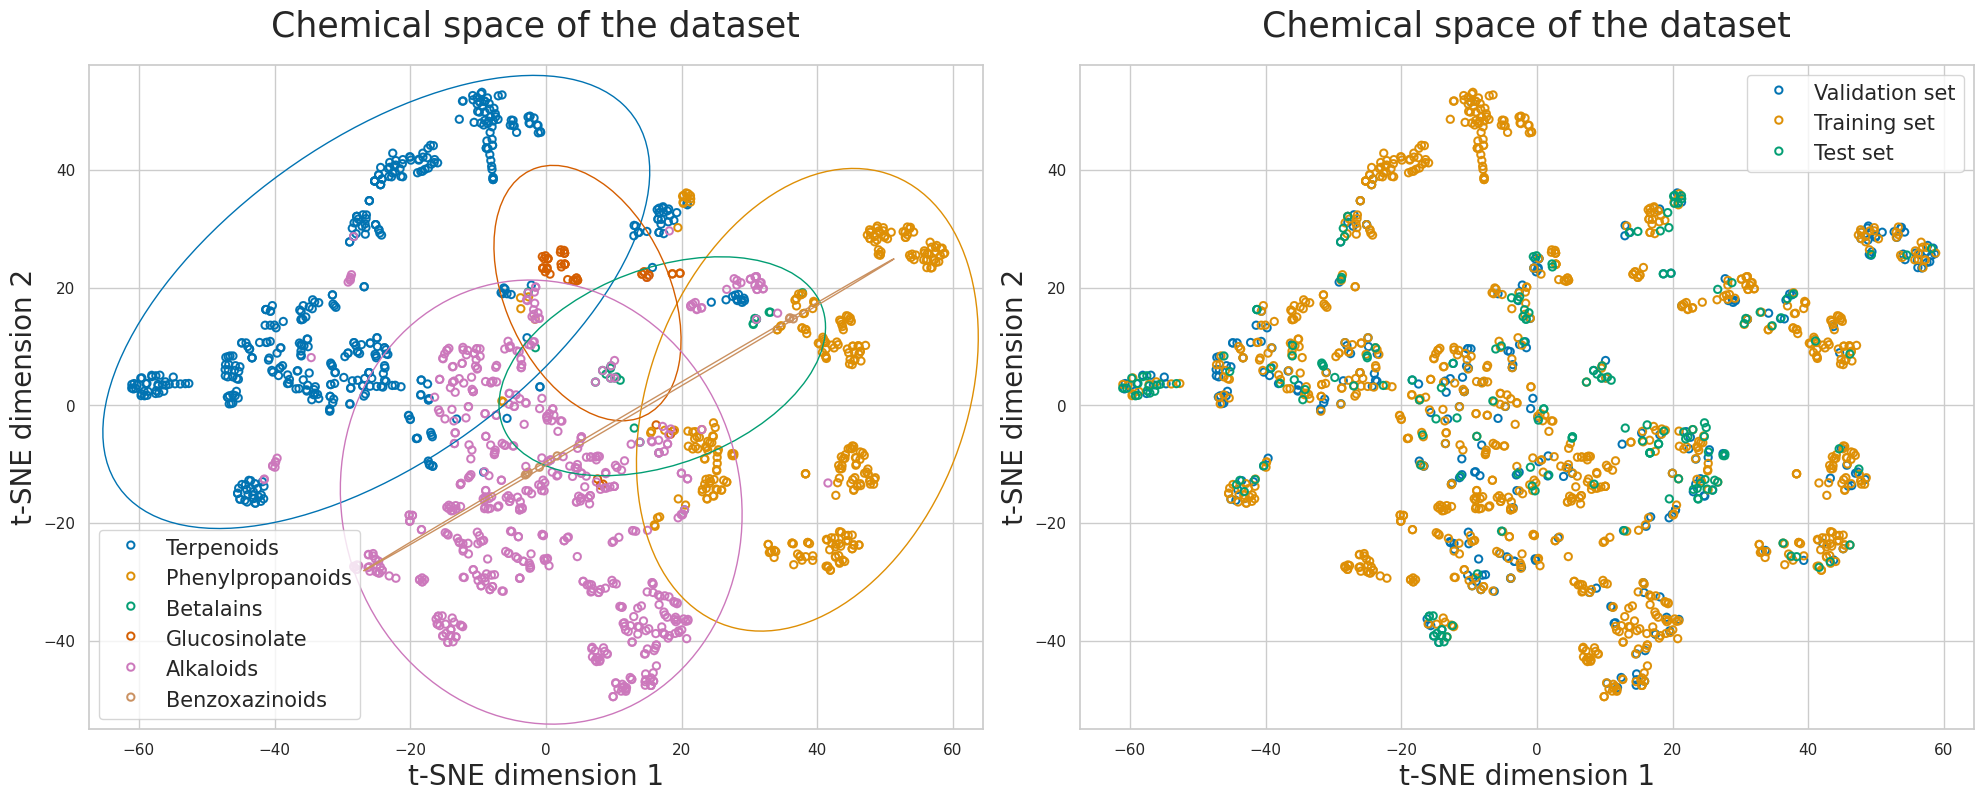

In [40]:
  # Increase the font scale

plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
create_tsne_graph(dataset, chemicalspace, "classes")
plt.subplot(2, 2, 2)
create_tsne_graph(dataset, chemicalspace, "set", set_=True)

#plt.subplot(3, 2, 5)
#create_tsne_graph(data, chemicalspace, "Tryptophan")

#plt.subplot(3, 2, 6)
#create_tsne_graph(data, chemicalspace, "Secologanin")

plt.tight_layout()
plt.show()

In [13]:
overlapping_test_set = []
for i, compound in enumerate(chemicalspace):
    if -10 < compound[0] < 10 and 10 < compound[1] < 30:
        overlapping_test_set.append(dataset.ids[i])
    elif 20 < compound[0] < 40 and 10 < compound[1] < 25:
        overlapping_test_set.append(dataset.ids[i])
    elif 15 < compound[0] < 26 and -22 < compound[1] < 0:
        overlapping_test_set.append(dataset.ids[i])
overlapping_test_set = np.array(overlapping_test_set)

In [14]:
whole_data = pd.read_csv("../final_dataset_top_v2.csv")
whole_data[whole_data.ids.isin(overlapping_test_set)].to_csv("challenging_datasets/overlapping_test_set.csv", index=False)
whole_data[~whole_data.ids.isin(overlapping_test_set)].to_csv("challenging_datasets/training_set_overlapping.csv", index=False)

In [15]:
# label if it is in the train, test or validation set
def label_test_train(id_):
    if id_ in overlapping_test_set:
        return "Overlapping set"
    return "Training set"
        
dataset['overlapping_set'] = dataset['ids'].apply(label_test_train)

/tmp/ipykernel_1532317/2519329965.py:35: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(ellipse_center, width, height, angle, color=scatter_palette[unique_classes.tolist().index(class_name)], fill=False)
/tmp/ipykernel_1532317/2519329965.py:35: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(ellipse_center, width, height, angle, color=scatter_palette[unique_classes.tolist().index(class_name)], fill=False)
/tmp/ipykernel_1532317/2519329965.py:35: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(ellipse_center, width, heig

<module 'matplotlib.pyplot' from '/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/matplotlib/pyplot.py'>

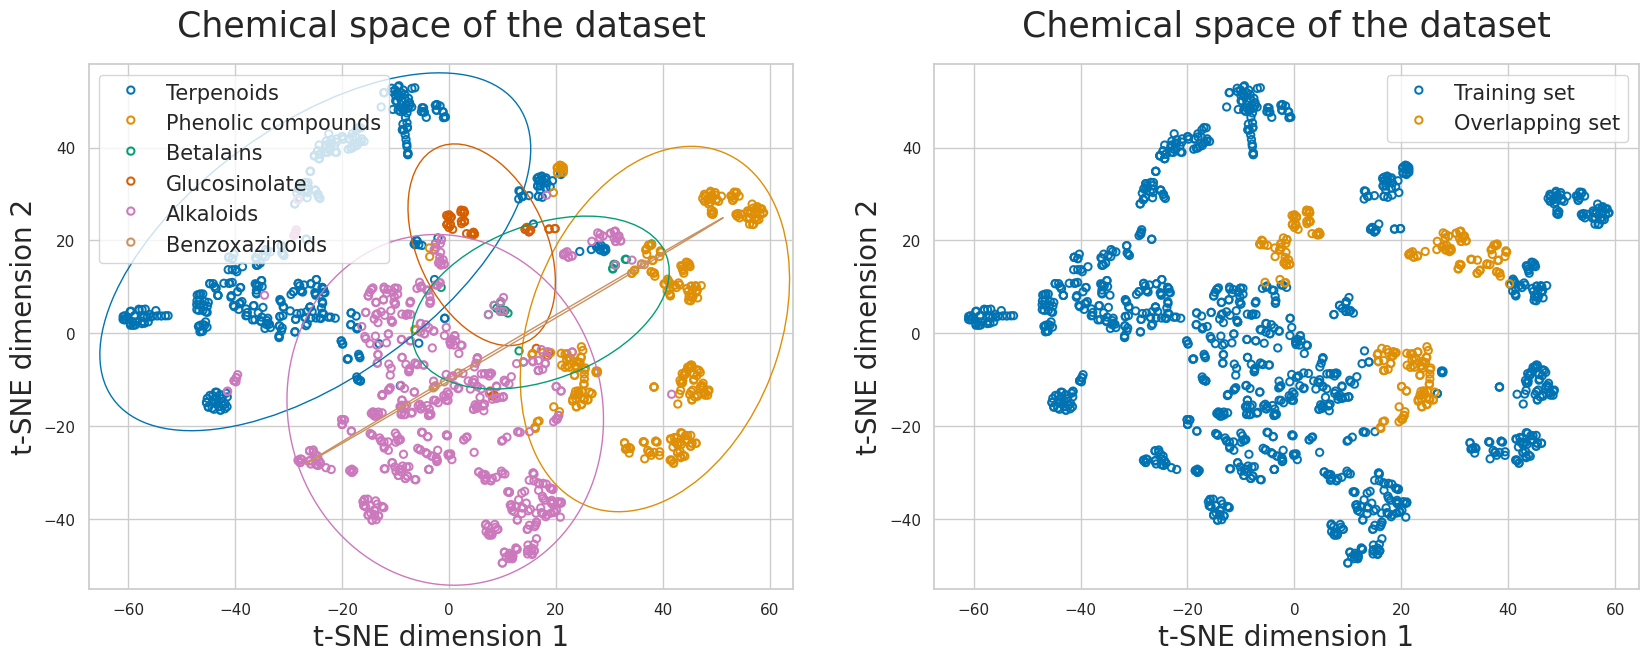

In [16]:
  # Increase the font scale

plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
create_tsne_graph(dataset, chemicalspace, "classes")
plt.subplot(2, 2, 2)
create_tsne_graph(dataset, chemicalspace, "overlapping_set", set_=True)

In [17]:
clustered_test_set = []
for i, compound in enumerate(chemicalspace):
    if 28 < compound[0] < 50 and -30 < compound[1] < 0:
        clustered_test_set.append(dataset.ids[i])
    elif -65 < compound[0] < -50 and 0 < compound[1] < 10:
        clustered_test_set.append(dataset.ids[i])
    elif -50 < compound[0] < -42.6 and -22 < compound[1] < -5:
        clustered_test_set.append(dataset.ids[i])
    elif -15 < compound[0] < 0 and 35 < compound[1] < 60:
        clustered_test_set.append(dataset.ids[i])
    elif 49 < compound[0] < 60 and 20 < compound[1] < 40:
        clustered_test_set.append(dataset.ids[i])
clustered_test_set = np.array(clustered_test_set)
len(clustered_test_set)

274

In [18]:
whole_data = pd.read_csv("../final_dataset_top_v2.csv")
whole_data[whole_data.ids.isin(clustered_test_set)].to_csv("challenging_datasets/clustered_test_set.csv", index=False)
whole_data[~whole_data.ids.isin(clustered_test_set)].to_csv("challenging_datasets/training_set_clustered.csv", index=False)

In [19]:
# label if it is in the train, test or validation set
def label_test_train(id_):
    if id_ in clustered_test_set:
        return "Clustered set"
    return "Training set"
        
dataset['clustered_set'] = dataset['ids'].apply(label_test_train)

/tmp/ipykernel_1532317/3576025874.py:35: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(ellipse_center, width, height, angle, color=scatter_palette[unique_classes.tolist().index(class_name)], fill=False)
/tmp/ipykernel_1532317/3576025874.py:35: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(ellipse_center, width, height, angle, color=scatter_palette[unique_classes.tolist().index(class_name)], fill=False)
/tmp/ipykernel_1532317/3576025874.py:35: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(ellipse_center, width, heig

<module 'matplotlib.pyplot' from '/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/matplotlib/pyplot.py'>

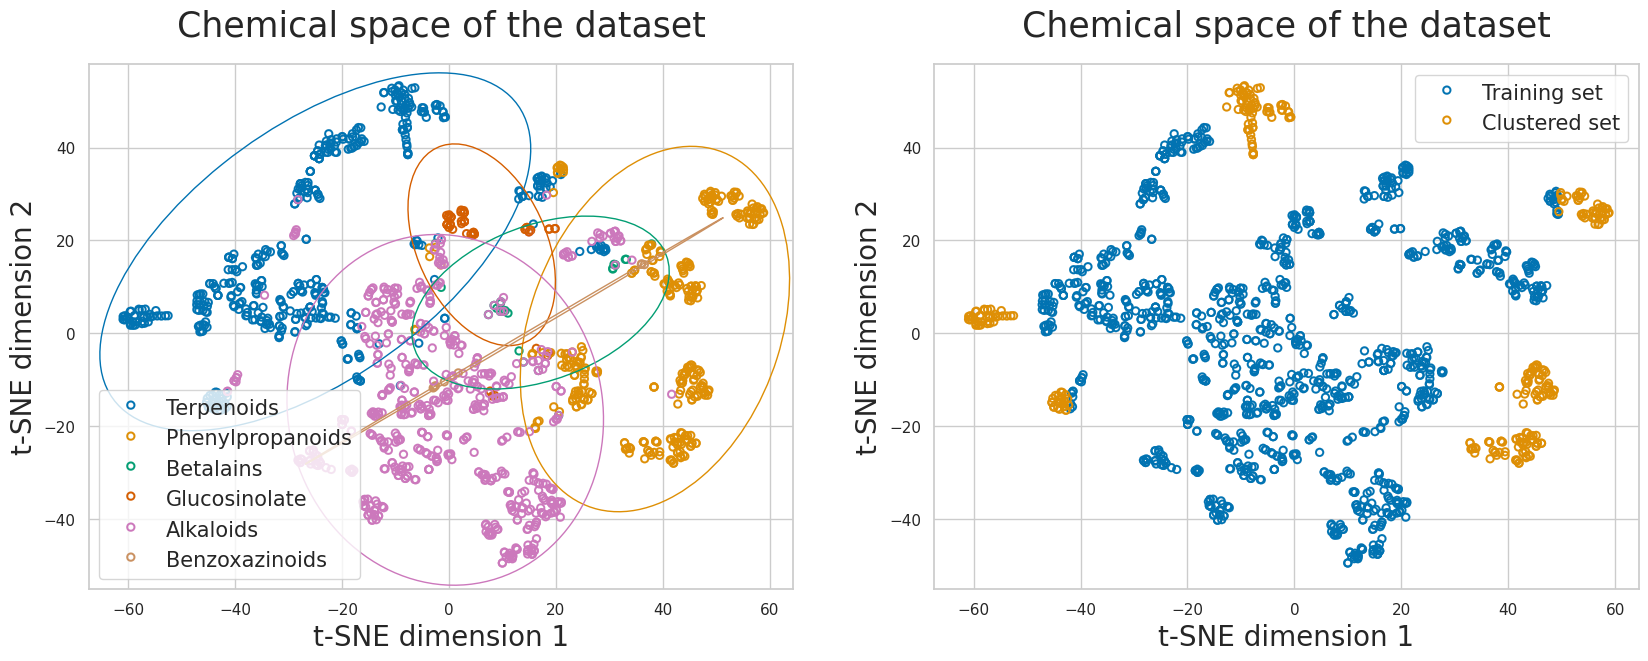

In [35]:
  # Increase the font scale

plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
create_tsne_graph(dataset, chemicalspace, "classes")
plt.subplot(2, 2, 2)
create_tsne_graph(dataset, chemicalspace, "clustered_set", set_=True)

/tmp/ipykernel_1532317/1347028071.py:35: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(ellipse_center, width, height, angle, color=scatter_palette[unique_classes.tolist().index(class_name)], fill=False)
/tmp/ipykernel_1532317/1347028071.py:35: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(ellipse_center, width, height, angle, color=scatter_palette[unique_classes.tolist().index(class_name)], fill=False)
/tmp/ipykernel_1532317/1347028071.py:35: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(ellipse_center, width, heig

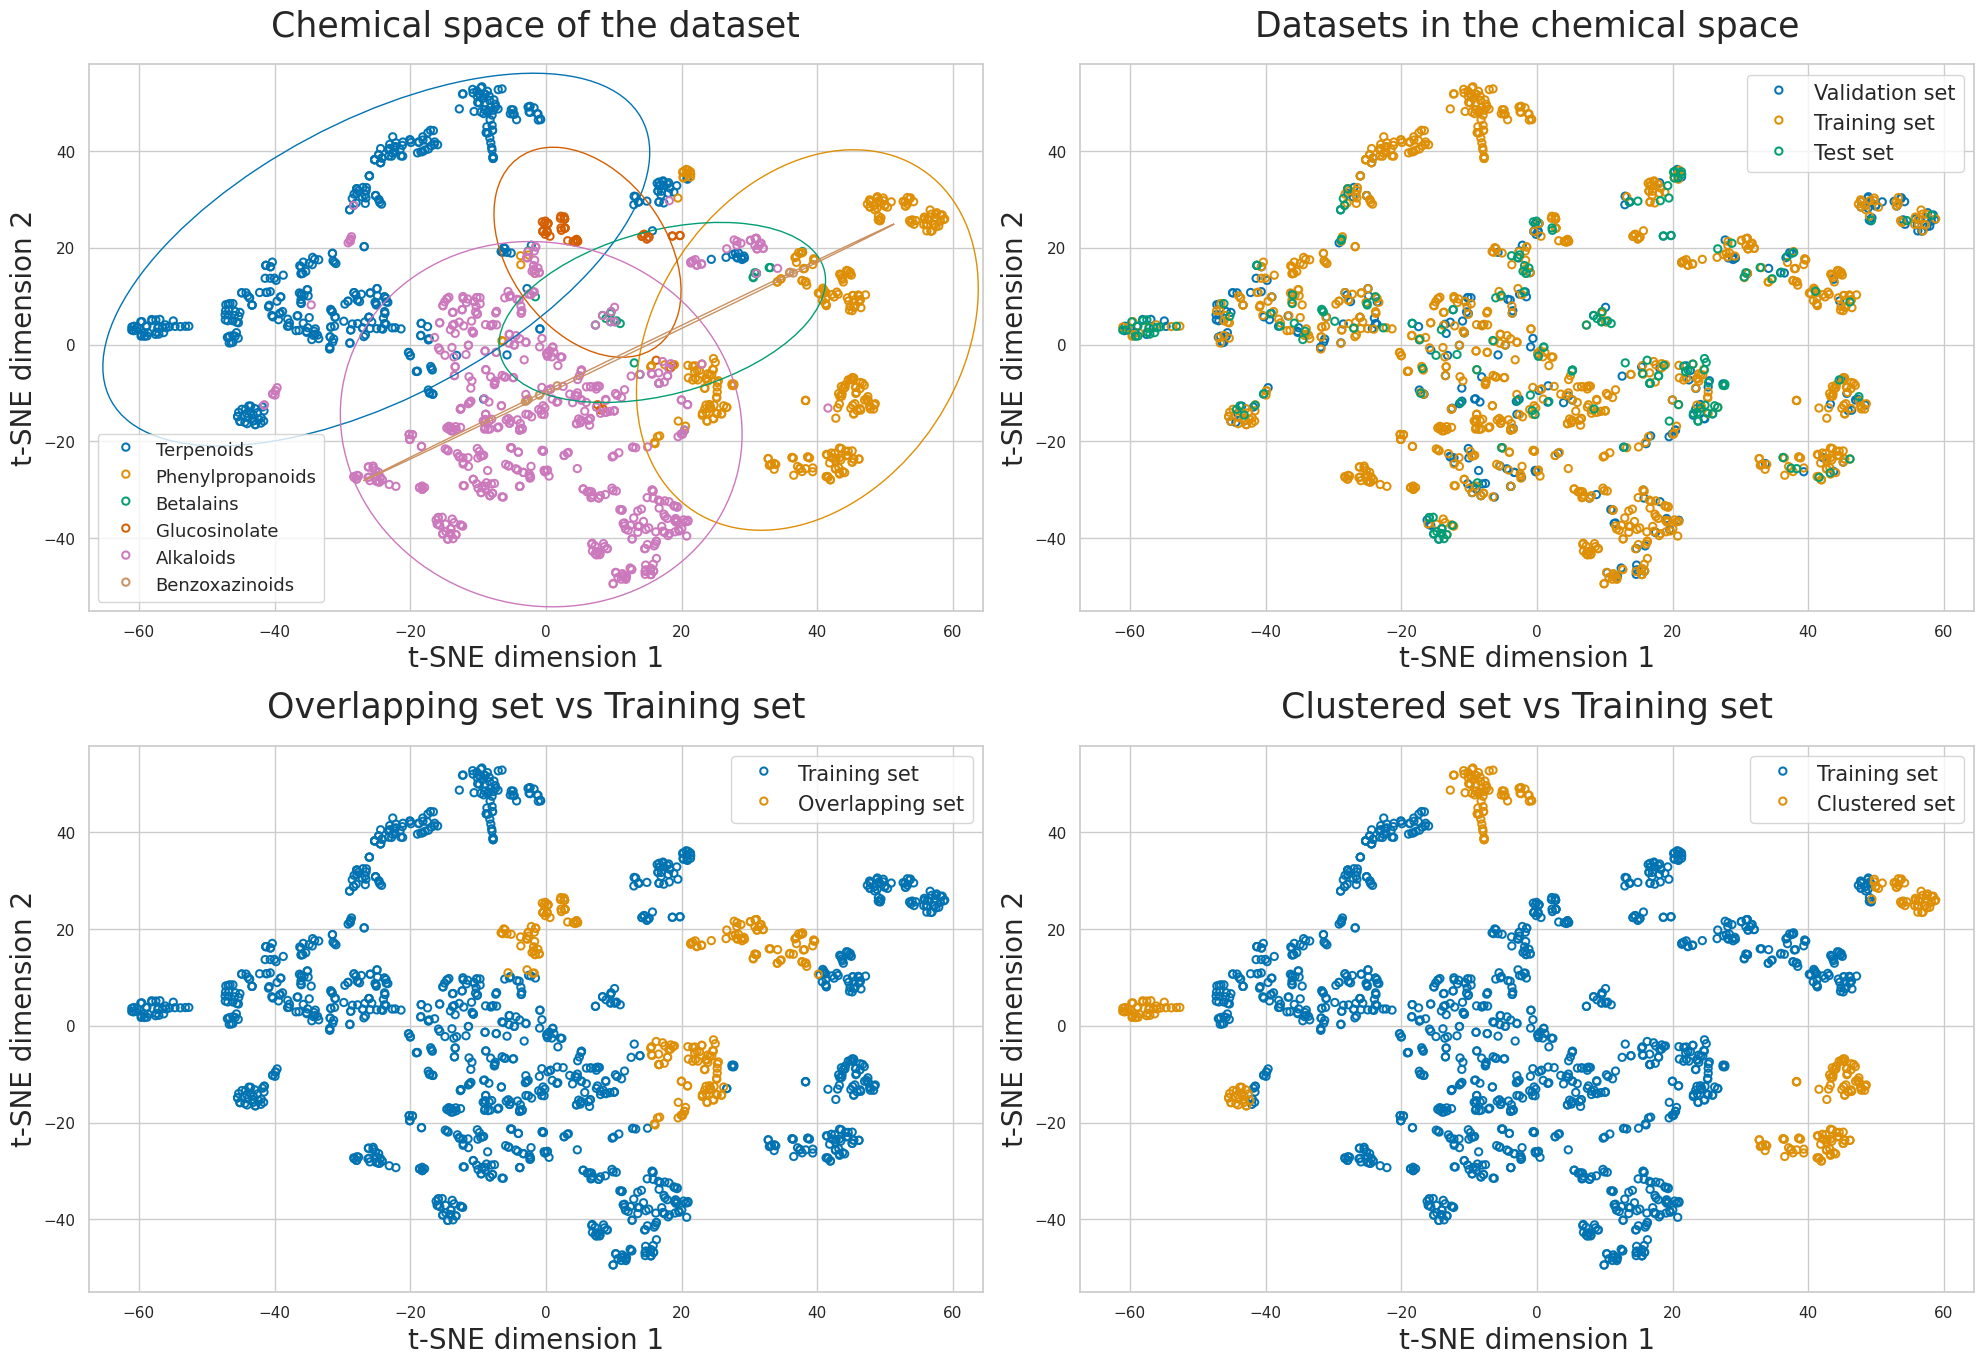

In [49]:

plt.figure(figsize=(20, 20))
plt.subplot(3, 2, 1)
create_tsne_graph(dataset, chemicalspace, "classes", set_=False,title="Chemical space of the dataset")
plt.subplot(3, 2, 2)
create_tsne_graph(dataset, chemicalspace, "set", set_=True, title="Datasets in the chemical space")

plt.subplot(3, 2, 3)
create_tsne_graph(dataset, chemicalspace, "overlapping_set", set_=True, title="Overlapping set vs Training set")

plt.subplot(3, 2, 4)
create_tsne_graph(dataset, chemicalspace, "clustered_set", set_=True, title="Clustered set vs Training set")

plt.tight_layout()
plt.show()

In [1]:
import pandas as pd

dataset = pd.read_csv("../final_dataset_top_v2.csv")
dataset

,ids,smiles,C00073,C00078,C00079,C00082,C00235,C00341,C00353,C00448,...,C00135,C00223,C00509,C00540,C01477,C05903,C05904,C05905,C05908,C09762
0,C02344,CC1(C)[C@@H]2CC[C@@](C)(C2)[C@@H]1O,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C02462,CC(C)[C@]12CC[C@@](C)(O)[C@H]1C2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,C03190,CC1(C)C2CCC1(C)[C@@H](OP(=O)(O)OP(=O)(O)O)C2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C06074,C=CC(=C)CCC=C(C)C,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,C00521,C=C(C)[C@@H]1CC=C(C)CC1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,C00002242,C1(C(C(C(C(O1)(OC2(C(C(C(OC2(C(O[H])([H])[H])[...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1424,C00030216,C1(C(C(C2(C(C1([H])[H])(C3(C(C(C2([H])[H])([H]...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1425,C00002264,O(C1(C(C=2C(C(C1([H])[H])([H])[H])(C3(C(C(C2[H...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1426,C00002265,C1(C(C(C(C(O1)(OC2(C(C(C(OC2(OC3(C(C=4C(C(C3([...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
coise = dataset[dataset["ids"]=="C15770"]
coise = coise[coise == 1]
# get non null column
coise = coise.dropna(axis=1)
coise

,C03506
540,1.0


In [2]:
labels = {
    'C00341': 'Geranyl diphosphate',
    'C01789': 'Campesterol',
    'C00078': 'Tryptophan',
    'C00049': 'L-Aspartate',
    'C00183': 'L-Valine',
    'C03506': 'Indoleglycerol phosphate',
    'C00187': 'Cholesterol',
    'C00079': 'L-Phenylalanine',
    'C00047': 'L-Lysine',
    'C01852': 'Secologanin',
    'C00407': 'L-Isoleucine',
    'C00129': 'Isopentenyl diphosphate',
    'C00235': 'Dimethylallyl diphosphate',
    'C00062': 'L-Arginine',
    'C00353': 'Geranylgeranyl diphosphate',
    'C00148': 'L-Proline',
    'C00073': 'L-Methionine',
    'C00108': 'Anthranilate',
    'C00123': 'L-Leucine',
    'C00135': 'L-Histidine',
    'C00448': 'Farnesyl diphosphate',
    'C00082': 'L-Tyrosine',
    'C00041': 'L-Alanine',
    'C00540': 'Cinnamoyl-CoA',
    'C01477': 'Apigenin',
    'C05903': 'Kaempferol',
    'C05904': 'Pelargonin',
    'C05905': 'Cyanidin',
    'C05908': 'Delphinidin',
    'C00389': 'Quercetin',
    'C01514': 'Luteolin',
    'C09762': "Liquiritigenin",
    'C00509': 'Naringenin',
    'C00223': 'p-Coumaroyl-CoA'
}

new_columns = []
for column in dataset.columns:
    if column in labels:
        new_columns.append(labels[column])
    else:
        new_columns.append(column)
        
dataset.columns=new_columns


In [3]:
dataset

,ids,smiles,L-Methionine,Tryptophan,L-Phenylalanine,L-Tyrosine,Dimethylallyl diphosphate,Geranyl diphosphate,Geranylgeranyl diphosphate,Farnesyl diphosphate,...,L-Histidine,p-Coumaroyl-CoA,Naringenin,Cinnamoyl-CoA,Apigenin,Kaempferol,Pelargonin,Cyanidin,Delphinidin,Liquiritigenin
0,C02344,CC1(C)[C@@H]2CC[C@@](C)(C2)[C@@H]1O,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C02462,CC(C)[C@]12CC[C@@](C)(O)[C@H]1C2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,C03190,CC1(C)C2CCC1(C)[C@@H](OP(=O)(O)OP(=O)(O)O)C2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C06074,C=CC(=C)CCC=C(C)C,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,C00521,C=C(C)[C@@H]1CC=C(C)CC1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,C00002242,C1(C(C(C(C(O1)(OC2(C(C(C(OC2(C(O[H])([H])[H])[...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1424,C00030216,C1(C(C(C2(C(C1([H])[H])(C3(C(C(C2([H])[H])([H]...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1425,C00002264,O(C1(C(C=2C(C(C1([H])[H])([H])[H])(C3(C(C(C2[H...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1426,C00002265,C1(C(C(C(C(O1)(OC2(C(C(C(OC2(OC3(C(C=4C(C(C3([...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


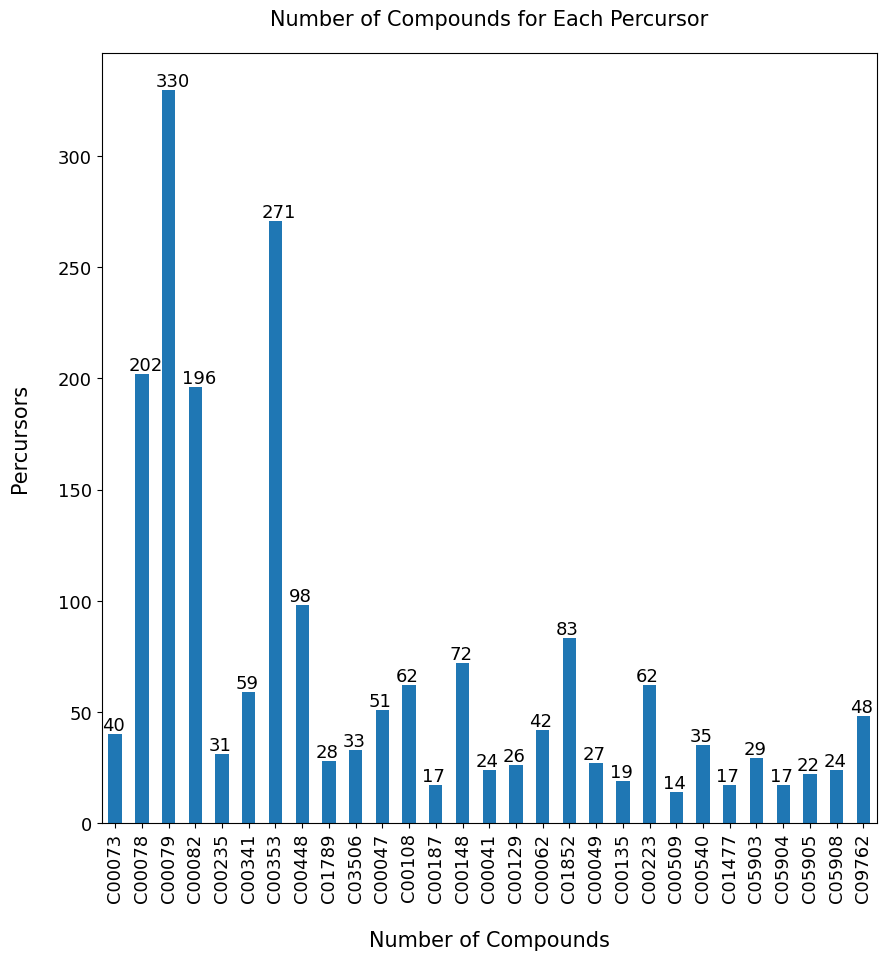

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Exclude 'ids' and 'smiles' columns from sum calculation
sum_ones = dataset.iloc[:, 2:].sum()

plt.figure(figsize=(10, 10))  
#modified_labels = sum_ones.index.tolist()
#modified_labels[0] = 'New Label'    
# Create the plot
sum_ones.plot(kind='bar')

#annotate with text
for i, v in enumerate(sum_ones.values):
    plt.text(i-0.5, v+4
    , str(int(v)), color='black', va='center', size=13)


# Add labels and title
plt.xlabel('Number of Compounds', fontsize=15, labelpad=20)
plt.ylabel('Percursors', fontsize=15, labelpad=20)
plt.title('Number of Compounds for Each Percursor', fontsize=15, pad=20)

plt.xticks(rotation=90, size=13)
plt.yticks(size=13)
# Display the plot
#plt.show()
plt.savefig("number_of_compounds.png", dpi=300)

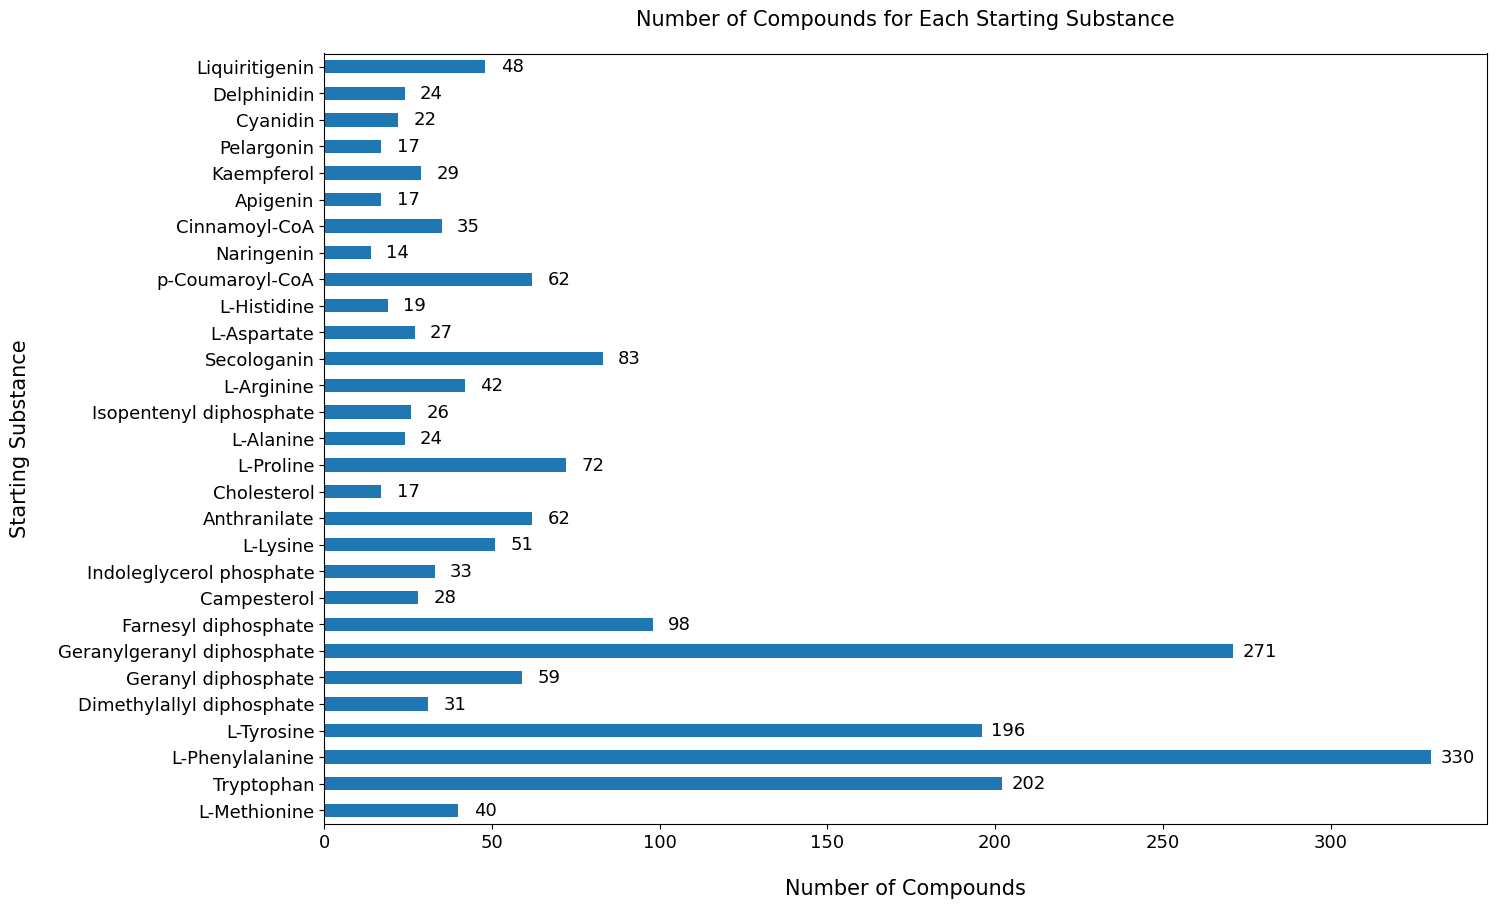

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'dataset' is already defined and loaded
# Exclude 'ids' and 'smiles' columns from sum calculation
sum_ones = dataset.iloc[:, 2:].sum()

plt.figure(figsize=(15, 10))
# Create the horizontal plot
sum_ones.plot(kind='barh')  # Change to 'barh' for horizontal bars

# Annotate with text
for i, v in enumerate(sum_ones.values):
    plt.text(v + 8, i-0.20, str(int(v)), color='black', ha='center', size=13)

# Add labels and title (Note the swap in labels for x and y)
plt.ylabel('Starting Substance', fontsize=15, labelpad=20)
plt.xlabel('Number of Compounds', fontsize=15, labelpad=20)  # Typo corrected from 'Percursors' to 'Precursors'
plt.title('Number of Compounds for Each Starting Substance', fontsize=15, pad=20)

# Adjust tick parameters for horizontal plot
plt.yticks(rotation=0, size=13)  # Rotate y ticks to horizontal
plt.xticks(size=13)  # Ensure x ticks are appropriately sized
# Display the plot
#plt.show()  # Use plt.show() if you want to display the plot inline (e.g., in a Jupyter notebook)
plt.savefig("number_of_compounds_horizontal.png", dpi=300) 